In [7]:
import nibabel as nib
from monai.data.utils import correct_nifti_header_if_necessary
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoTokenizer, BitsAndBytesConfig, AutoModelForCausalLM
import os
import numpy as np
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [8]:
image_file_path = "/home/lez/Siyou/Med3DLLM/datasets/AMOS-MM/imagesVa/amos_0013.nii.gz"
lamed_model_path = "/pfs/mt-1oY5F7/luoyihao/project/multimodal/AMOS-MM/M3D/LaMed/output/LaMed-Asclepius8b-0903-mrg-lora/checkpoint-5088"
lora_weight_path = "/pfs/mt-1oY5F7/luoyihao/project/multimodal/AMOS-MM/M3D/LaMed/output/LaMed-Asclepius8b-0903-mrg-lora/model_with_lora.bin"

In [17]:
image_file_path = "/home/lez/Siyou/Med3DLLM/datasets/AMOS-MM/imagesVa/amos_0034.nii.gz"
nifti_img = nib.load(image_file_path)
nifti_img = correct_nifti_header_if_necessary(nifti_img)
img_array = nifti_img.get_fdata()
print(img_array.shape)
# mean = np.mean(img_array)
# std = np.std(img_array)
# img_array = (img_array - mean) / std
max_val = np.max(img_array)
min_val = np.min(img_array)
img_array = (img_array - min_val) / (max_val - min_val)

img_data = torch.from_numpy(img_array)
img_data = img_data.permute(2, 0, 1)  # shape: (D, H, W)
warp_img = img_data.unsqueeze(0).unsqueeze(0) 
warp_img = warp_img.half()
warp_img = F.interpolate(warp_img, size=(32, 256, 256), mode='trilinear', align_corners=True)
warp_img = warp_img.squeeze(0).squeeze(0)
print(warp_img.max(), warp_img.min())
img_array = warp_img.numpy()
img_array = np.transpose(img_array, (2, 0, 1))
img_array = np.expand_dims(img_array, axis=0)


(512, 512, 103)
tensor(0.9937, dtype=torch.float16) tensor(0., dtype=torch.float16)


In [4]:
warp_img.shape

torch.Size([32, 256, 256])

0.982 0.0


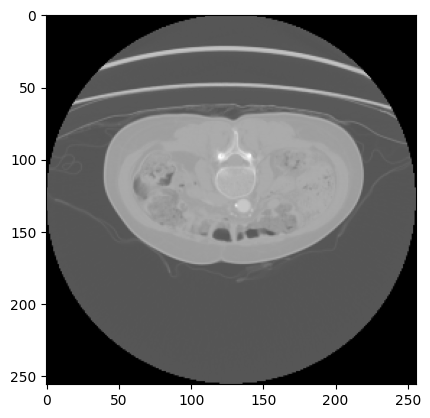

In [5]:
import matplotlib.pyplot as plt
plt.imshow(img_array[0, :, 16, :], cmap='gray')
#plt.imshow(warp_img[16, :, :], cmap='gray')
print(img_array.max(), img_array.min())

In [10]:
def find_all_linear_names(model):
    cls = torch.nn.Linear
    lora_module_names = set()
    # Process of elimination: LoRA only targets on LLM backbone
    ignore_keywords = ['vision_tower', 'mm_projector', 'embed_tokens', 'lm_head', 'seg_projector', 'seg_module']
    for name, module in model.named_modules():
        if any(mm_keyword in name for mm_keyword in ignore_keywords):
            continue
        if isinstance(module, cls):
            lora_module_names.add(name)
    return list(lora_module_names)

def load_model(lamed_model_path, lora_weight_path=None):
    tokenizer = AutoTokenizer.from_pretrained(
        lamed_model_path,
        model_max_length=512,
        padding_side="right",
        use_fast=False,
        pad_token="<unk>",
        trust_remote_code=True
    )
    lamed_model = AutoModelForCausalLM.from_pretrained(
        lamed_model_path,
        trust_remote_code=True,
        
    )
    if lora_weight_path:
        from peft import LoraConfig, get_peft_model
        lora_config = LoraConfig(
            r=16,
            lora_alpha=32,
            target_modules=find_all_linear_names(lamed_model),
            lora_dropout=0.05,
            bias="none",
            task_type="CAUSAL_LM",
        )
        print("Adding LoRA adapters only on LLM.")
        lamed_model = get_peft_model(lamed_model, lora_config)
        # lamed_model.print_trainable_parameters()
        print("Load weights with LoRA")
        state_dict = torch.load(lora_weight_path, map_location="cuda")
        lamed_model.load_state_dict(state_dict, strict=True)
        print("Merge weights with LoRA")
        lamed_model = lamed_model.merge_and_unload()
        
    lamed_model = lamed_model.to("cuda")
    lamed_model.eval()
    return tokenizer, lamed_model

tokenizer, lamed_model = load_model(lamed_model_path, lora_weight_path)


/pfs/mt-1oY5F7/luoyihao/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/pfs/mt-1oY5F7/luoyihao/anaconda3/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.blocks.patchembedding PatchEmbeddingBlock.__init__:pos_embed: Argument `pos_embed` has been deprecated since version 1.2. It will be removed in version 1.4. please use `proj_type` instead.
  warn_deprecated(argname, msg, warning_category)
Some weights of the model checkpoint at /pfs/mt-1oY5F7/luoyihao/project/multimodal/AMOS-MM/M3D/LaMed/output/LaMed-Asclepius8b-0903-mrg-lora/checkpoint-5088 were not used when initializing LamedLlamaForCausalLM: ['base_model.model.lm_head.weight', 'base_model.model.model.embed_tokens.weight', 'base_model.model.model.layers.0.input_layernorm.weight', 'base_model.model.model.layers.0.mlp.down_proj.b

Adding LoRA adapters only on LLM.
Load weights with LoRA
Merge weights with LoRA


In [7]:
vit_layers_params_num = 0
for name, module in lamed_model.named_modules():
        if any(mm_keyword in name for mm_keyword in ["vision_tower"]):
            vit_layers_params_num += sum(p.numel() for p in module.parameters())
print(f"Total number of parameters in vision tower: {vit_layers_params_num}")
mm_projector_params_num = 0
for name, module in lamed_model.named_modules():
    if any(mm_keyword in name for mm_keyword in ["mm_projector"]):
        mm_projector_params_num += sum(p.numel() for p in module.parameters())
print(f"Total number of parameters in mm_projector: {mm_projector_params_num}")

Total number of parameters in vision tower: 518784768
Total number of parameters in mm_projector: 59793408


In [8]:
# mrg
lamed_model.eval()
raw_question = "please provide a detailed caption outlining the finding in {} of this image.".format("pelvis")
image_tokens = "<im_patch>" * 256
question = image_tokens + ' ' + raw_question
print("question:", raw_question)
image = torch.unsqueeze(warp_img, 0).to(torch.float32)
image = torch.unsqueeze(image, 0).to("cuda")
print("image shape:",image.shape)
question_tensor = tokenizer(
            question, max_length=512, truncation=True, return_tensors="pt"
        )['input_ids'].to("cuda")
_, position_ids, attention_mask, past_key_values, inputs_embeds, labels = lamed_model.prepare_inputs_for_multimodal(question_tensor, None, None, None, None, image)
 
generation = lamed_model.generate(
    image, question_tensor, seg_enable=False, max_new_tokens=256,\
    do_sample=True, top_p=0.9, temperature=1
    )
output_str = tokenizer.batch_decode(generation, skip_special_tokens=True)[0]
print("output_str:", output_str)

question: please provide a detailed caption outlining the finding in pelvis of this image.
image shape: torch.Size([1, 1, 32, 256, 256])
output_str:  The prostate volume is not large, the contour is smooth, the density is uniform, and no obvious abnormality is detected. The bladder neck is clear, the bladder wall is smooth, and no obvious localized thickening or nodular shadow is detected. No enlarged lymph nodes are detected in the pelvic cavity.


In [8]:
question_tensor

tensor([[128000, 128002, 128002, 128002, 128002, 128002, 128002, 128002, 128002,
         128002, 128002, 128002, 128002, 128002, 128002, 128002, 128002, 128002,
         128002, 128002, 128002, 128002, 128002, 128002, 128002, 128002, 128002,
         128002, 128002, 128002, 128002, 128002, 128002, 128002, 128002, 128002,
         128002, 128002, 128002, 128002, 128002, 128002, 128002, 128002, 128002,
         128002, 128002, 128002, 128002, 128002, 128002, 128002, 128002, 128002,
         128002, 128002, 128002, 128002, 128002, 128002, 128002, 128002, 128002,
         128002, 128002, 128002, 128002, 128002, 128002, 128002, 128002, 128002,
         128002, 128002, 128002, 128002, 128002, 128002, 128002, 128002, 128002,
         128002, 128002, 128002, 128002, 128002, 128002, 128002, 128002, 128002,
         128002, 128002, 128002, 128002, 128002, 128002, 128002, 128002, 128002,
         128002, 128002, 128002, 128002, 128002, 128002, 128002, 128002, 128002,
         128002, 128002, 128